#### Code for Figure 1 

### - Fig 2: Temperature comparison model vs obs
####        - Same year?
####        - Consider seasonality? Not at the moment, because comparison with seal data would be difficult. 
####        - Start making a map with both / Deep layer? 400m? More?

#### Get Adele's seal code from the vrtual machine. And then have to learn how to load the obs data in as .mat


In [21]:
pwd

'/home/581/ns3783'

In [22]:
%matplotlib inline

import cosima_cookbook as cc
import cmocean.cm as cm

#had to add these two lines because figure was savin empty
import matplotlib
matplotlib.use('Agg')  
#added these package two and a line on the plot, but it doesn't seem to change anything
import time

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
from glob import glob
import dask
import os
import datetime
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
from scipy import interpolate


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [23]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46703/status,
Dashboard: /proxy/46703/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43251,Workers: 7
Dashboard: /proxy/46703/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:38137,Total threads: 4
Dashboard: /proxy/45397/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:44559,


In [24]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

### Load temperature data at determined depth

In [25]:
##initially I calculated the model just for 2012, but after having a look on what sort of data the seals had, I decided to do all months from 2004-2018,
## so we would be covering the same period on both
first_year = '2004'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# load temperature data at 400m:

depth_slice = 400
# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)


In [26]:
temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_400m = temp_400m.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

In [27]:
#just 2012 / this calculates the average for the season, but I no longer want that
#temp_400m_12 = temp_400m.groupby('time.season').mean('time')
#temp_400m_12 = temp_400m_12.loc['MAM',:,:]
temp_400m_12 = temp_400m.mean('time')


In [28]:
temp_400m_12

<xarray.DataArray 'temp' (yt_ocean: 357, xt_ocean: 450)> Size: 643kB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [1.8752851, 1.7590264, 1.6235045, ..., 2.8709393, 2.8721282,
        2.8731303],
       [1.8831215, 1.7673377, 1.6280769, ..., 2.8723164, 2.8730688,
        2.8737733],
       [1.887139 , 1.7667518, 1.6262869, ..., 2.8739889, 2.8743222,
        2.874674 ]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 4kB -274.9 -274.8 -274.7 ... -230.1 -230.0
  * yt_ocean  (yt_ocean) float64 3kB -75.49 -75.45 -75.41 ... -60.1 -60.05
    st_ocean  float64 8B 383.0

### Bathymetry

In [29]:
# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [30]:
#Prepping variables to plot
fontsize=14

    #for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)        
pc = plt.pcolormesh(temp_400m_12.xt_ocean,temp_400m_12.yt_ocean,
                        temp_400m_12, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
#plt.title('2012 (March-May)',fontsize=fontsize)
plt.title('2004-2018',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -63))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=16)

#figdir = '/g/data/jk72/ns3783'
#filestr = figdir+'/Figure1a_model_2004_2018.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

#### LOAD SEALS 

## Get model grid data and temperature climatology:

## Select out profiles in correct region:

#### Improvements on this figure: take out winter profiles, sort profiles 
#### Fix it in a way they don't go much shallower than 400m. 

## Interpolate MEOP profiles onto model depth grid and convert to conservative temp:


### Interpolating the seal data to the model grid. >> this is working know, but I am not sure what exactly I have done that got it right. 

In [31]:
#

### saving data

## Open saved seal data:

In [32]:
outpath = '/g/data/v45/ns3783/VB_MEOP_profiles_interpolated_conserv.nc'
profile_data = xr.open_dataset(outpath)
lat_obs = profile_data.lat_obs
lon_obs = profile_data.lon_obs
month_obs = profile_data.month_obs
year_obs = profile_data.year_obs
temp_interp = profile_data.temp_interp
date = profile_data.date

# need to assign lat/lon coords for binning:
temp_interp = temp_interp.assign_coords({'lon':lon_obs,'lat':lat_obs})

In [33]:
np.unique(year_obs)

array([2004., 2005., 2007., 2008., 2009., 2010., 2011., 2012., 2013.,
       2014., 2015., 2016., 2017., 2018., 2019.])

### Establish how many profiles per year


### First we have to copy the profile_data and trimm it to the size of the map. 
#### The reason we can't do this earlier is because data is binned for the map and neighbouring points that aren't displayed on the map might be included in the map through binning. 

In [34]:
# Create a copy of the profile_data dataset
profile_data_copy = profile_data.copy()

# Slice the dataset based on latitude and longitude values
lat_min = -67  # Example latitude minimum value
lat_max = -64  # Example latitude maximum value
lon_min = -255  # Example longitude minimum value
lon_max = -248  # Example longitude maximum value

# Slice latitude
profile_data_copy = profile_data_copy.where((profile_data_copy.lat_obs >= lat_min) & (profile_data_copy.lat_obs <= lat_max), drop=True)

# Slice longitude
profile_data_copy = profile_data_copy.where((profile_data_copy.lon_obs-360 >= lon_min) & (profile_data_copy.lon_obs-360 <= lon_max), drop=True)

# Print the sliced dataset
print(profile_data_copy)


<xarray.Dataset> Size: 2MB
Dimensions:         (profile_number: 5403, st_ocean: 50)
Coordinates:
  * profile_number  (profile_number) int64 43kB 85 86 87 ... 29493 29494 29495
  * st_ocean        (st_ocean) float64 400B 0.5413 1.681 ... 1.22e+03 1.333e+03
Data variables:
    temp_interp     (profile_number, st_ocean) float64 2MB nan nan ... nan nan
    lon_obs         (profile_number) float64 43kB 105.5 105.7 ... 105.7 105.9
    lat_obs         (profile_number) float64 43kB -65.02 -65.06 ... -64.97
    month_obs       (profile_number) float64 43kB 3.0 3.0 3.0 ... 3.0 3.0 3.0
    year_obs        (profile_number) float64 43kB 2.015e+03 ... 2.019e+03
    date            (profile_number) object 43kB 2015-03-01 22:40:00.000004 ....


In [35]:
# Get unique years from the year_obs array
unique_years = np.unique(profile_data_copy['year_obs'])

# Count the occurrences of each unique year
profiles_per_year = {year: np.count_nonzero(profile_data_copy['year_obs'] == year) for year in unique_years}

# Print the counts of profiles per year
for year, count in profiles_per_year.items():
    print(f"Year {year}: {count} profiles")

Year 2004.0: 15 profiles
Year 2005.0: 13 profiles
Year 2008.0: 94 profiles
Year 2009.0: 117 profiles
Year 2012.0: 4747 profiles
Year 2013.0: 183 profiles
Year 2014.0: 9 profiles
Year 2015.0: 158 profiles
Year 2017.0: 5 profiles
Year 2018.0: 2 profiles
Year 2019.0: 60 profiles


### Establish how many profiles per month

In [36]:
# Get unique years from the year_obs array
unique_mths = np.unique(profile_data_copy['month_obs'])

# Count the occurrences of each unique year
profiles_per_mth = {month: np.count_nonzero(profile_data_copy['month_obs'] == month) for month in unique_mths}

# Print the counts of profiles per year
for month, count in profiles_per_mth.items():
    print(f"Month {month}: {count} profiles")

Month 2.0: 82 profiles
Month 3.0: 1555 profiles
Month 4.0: 2044 profiles
Month 5.0: 1069 profiles
Month 6.0: 361 profiles
Month 7.0: 16 profiles
Month 8.0: 29 profiles
Month 9.0: 106 profiles
Month 10.0: 110 profiles
Month 11.0: 31 profiles


### SI Histogram Distribution of time for seal profiles

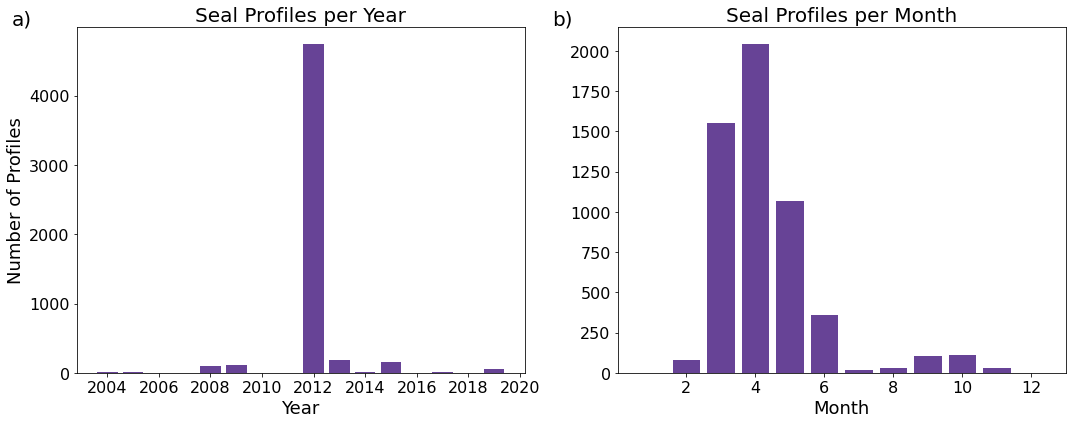

In [20]:
%matplotlib inline

# Data for profiles per month and year
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
profiles_per_month = [0, 82, 1555, 2044, 1069, 361, 16, 29, 106, 110, 31, 0]

years = [2004, 2005, 2008, 2009, 2012, 2013, 2014, 2015, 2017, 2018, 2019]
profiles_per_year = [15, 13, 94, 117, 4747, 183, 9, 158, 5, 2, 60]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot profiles per year
axs[0].bar(years, profiles_per_year, color=cm.thermal(0.3))
axs[0].set_title('Seal Profiles per Year', fontsize=20)
axs[0].set_xlabel('Year', fontsize=18)
axs[0].set_ylabel('Number of Profiles', fontsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=16)

# Add (a) label
axs[0].text(-0.1, 1.05, 'a)', transform=axs[0].transAxes, fontsize=20, va='top', ha='right')

# Plot profiles per month
axs[1].bar(months, profiles_per_month, color=cm.thermal(0.3))
axs[1].set_title('Seal Profiles per Month', fontsize=20)
axs[1].set_xlabel('Month', fontsize=18)
axs[1].set_ylabel('Number of Profiles', fontsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=16)

# Add (b) label
axs[1].text(-0.1, 1.05, 'b)', transform=axs[1].transAxes, fontsize=20, va='top', ha='right')

# Remove ylabel for subplot 2
axs[1].set_ylabel('')

# Adjust layout
plt.tight_layout()

# Save the plot
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir + 'SI_histogram_seal_distribution.png'
plt.savefig(filestr, dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


## Create plot that shows the distribution per year and month. 
### Design 11 panels, one for each available year and colour the profiles per month. 

### Have to call model bathymetry if we don't load the model data at the beginning

In [37]:
# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [38]:
profile_data

<xarray.Dataset> Size: 13MB
Dimensions:         (profile_number: 29496, st_ocean: 50)
Coordinates:
  * profile_number  (profile_number) int64 236kB 0 1 2 3 ... 29493 29494 29495
  * st_ocean        (st_ocean) float64 400B 0.5413 1.681 ... 1.22e+03 1.333e+03
Data variables:
    temp_interp     (profile_number, st_ocean) float64 12MB ...
    lon_obs         (profile_number) float64 236kB ...
    lat_obs         (profile_number) float64 236kB ...
    month_obs       (profile_number) float64 236kB ...
    year_obs        (profile_number) float64 236kB 2.015e+03 ... 2.019e+03
    date            (profile_number) object 236kB ...

## OLD ONE

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
years = np.array([2004, 2005, 2008, 2009, 2012, 2013, 2014, 2015, 2017, 2018, 2019])

# Calculate number of subplots needed based on available years
num_years = len(years)
num_cols = 3
num_rows = -(-num_years // num_cols)  # Ceiling division to ensure enough rows

# Create a figure with subplots for years with data
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 16))

# Alphabet for subplot indexes
alphabet = 'abcdefghijklmnopqrstuvwxyz'

# Loop through each year
for i, year in enumerate(years):
    # Replace with actual data from profile_data
    year_data = profile_data_copy['year_obs'].values  # Get the array of year data
    indices = np.where(year_data == year)[0]  # Get the indices where year_obs equals the current year
    
    # Check if there are any data points for the current year
    if len(indices) > 0:
        lat_data = profile_data_copy['lat_obs'].values[indices]  # Get latitude data corresponding to the indices
        lon_data = profile_data_copy['lon_obs'].values[indices] - 360  # Get longitude data corresponding to the indices
        month_data = profile_data_copy['month_obs'].values[indices]  # Get month data corresponding to the indices

        # Scatter plot of latitude and longitude with color based on month
        scatter = axs[i // num_cols, i % num_cols].scatter(lon_data, lat_data, c=month_data, cmap='viridis', alpha=0.7, vmin=1, vmax=12)

        # Plot contours
        axs[i // num_cols, i % num_cols].contour(ht.xt_ocean, ht.yt_ocean, ht, levels=[600, 800, 1000, 2000, 3000], colors='gray', linewidths=0.5)

        # Plot land mask
        axs[i // num_cols, i % num_cols].contourf(ht.xt_ocean, ht.yt_ocean, land_mask, colors='grey')

        # Set subplot title
        axs[i // num_cols, i % num_cols].set_title(f'Year {year}', fontsize=18)

        # Set tick parameters
        axs[i // num_cols, i % num_cols].tick_params(labelsize=16)

        # Set limits
        axs[i // num_cols, i % num_cols].set_ylim((-67, -64))
        axs[i // num_cols, i % num_cols].set_xlim((-255, -248))

        # Set tick labels
        axs[i // num_cols, i % num_cols].set_xticklabels([-255+359, -254+359, -253+359, -252+359, -251+359, -250+359, -249+359, -248+359])
        
        # Add colorbar with fixed scale from 1 to 12
        cbar = plt.colorbar(scatter, ax=axs[i // num_cols, i % num_cols], ticks=np.arange(1, 13))
        cbar.set_label('Month', fontsize=16)
        cbar.set_ticks(np.arange(1, 13))
        cbar.set_ticklabels(np.arange(1, 13), fontsize=16)


#        # Remove the colorbar for specified subplots
#        if (i + 1) in remove_colorbars:  # Convert to 1-based index for comparison
#            cbar.remove()

        
        # Add subplot indexes (a), b), c)) - first argument moves it horizontally, second argument moves it vertically
        axs[i // num_cols, i % num_cols].text(-0.2, 1.15, f'{alphabet[i]})', transform=axs[i // num_cols, i % num_cols].transAxes, fontsize=20, va='top', ha='right')

    else:
        # Hide empty subplot
        axs[i // num_cols, i % num_cols].set_visible(False)

# to remove last plot
axs.flat[-1].set_visible(False) 

# Add overall xlabel and ylabel and title
fig.text(0.5, -0.01, 'Longitude ($^\circ$)', ha='center', va='center', fontsize=18)
fig.text(-0.02, 0.5, 'Latitude ($^\circ$)', ha='center', va='center', rotation='vertical', fontsize=18)
fig.text(0.5, 1.01, 'Seal Profiles Distribution by Year', ha='center', va='center', fontsize=20)

# Adjust layout
plt.tight_layout()

# Save the plot
#figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
##plt.savefig(filestr, dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

## The one where colorbars of specific plots are removed, but plots change size

In [47]:

import matplotlib.pyplot as plt
import numpy as np

# Sample data
years = np.array([2004, 2005, 2008, 2009, 2012, 2013, 2014, 2015, 2017, 2018, 2019])

# Calculate number of subplots needed based on available years
num_years = len(years)
num_cols = 3
num_rows = -(-num_years // num_cols)  # Ceiling division to ensure enough rows

# Create a figure with subplots for years with data
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 16))

# Alphabet for subplot indexes
alphabet = 'abcdefghijklmnopqrstuvwxyz'
# Colorbar removal configuration
remove_colorbars = [1, 2, 4, 5, 7, 8, 10]  # Subplots for which to remove the colorbar (1-indexed)

# Adjusted loop for creating subplots
for i, year in enumerate(years):
    # Replace with actual data from profile_data
    year_data = profile_data_copy['year_obs'].values  # Get the array of year data
    indices = np.where(year_data == year)[0]  # Get the indices where year_obs equals the current year

    # Check if there are any data points for the current year
    if len(indices) > 0:
        lat_data = profile_data_copy['lat_obs'].values[indices]  # Get latitude data corresponding to the indices
        lon_data = profile_data_copy['lon_obs'].values[indices] - 360  # Get longitude data corresponding to the indices
        month_data = profile_data_copy['month_obs'].values[indices]  # Get month data corresponding to the indices

        # Scatter plot of latitude and longitude with color based on month
        scatter = axs[i // num_cols, i % num_cols].scatter(
            lon_data, lat_data, c=month_data, cmap='viridis', alpha=0.7, vmin=1, vmax=12
        )

        # Plot contours
        axs[i // num_cols, i % num_cols].contour(
            ht.xt_ocean, ht.yt_ocean, ht, levels=[600, 800, 1000, 2000, 3000], colors='gray', linewidths=0.5
        )

        # Plot land mask
        axs[i // num_cols, i % num_cols].contourf(ht.xt_ocean, ht.yt_ocean, land_mask, colors='grey')

        # Set subplot title
        axs[i // num_cols, i % num_cols].set_title(f'Year {year}', fontsize=18)

        # Set tick parameters
        axs[i // num_cols, i % num_cols].tick_params(labelsize=16)

        # Set limits
        axs[i // num_cols, i % num_cols].set_ylim((-67, -64))
        axs[i // num_cols, i % num_cols].set_xlim((-255, -248))

        # Set tick labels
        axs[i // num_cols, i % num_cols].set_xticklabels([-255 + 359, -254 + 359, -253 + 359, -252 + 359, -251 + 359, -250 + 359, -249 + 359, -248 + 359])

        # Add colorbar with fixed scale from 1 to 12
        cbar = plt.colorbar(scatter, ax=axs[i // num_cols, i % num_cols], ticks=np.arange(1, 13))
        cbar.set_label('Month', fontsize=16)
        cbar.set_ticks(np.arange(1, 13))
        cbar.set_ticklabels(np.arange(1, 13), fontsize=16)

        # Remove the colorbar for specified subplots
        if (i + 1) in remove_colorbars:  # Convert to 1-based index for comparison
            cbar.remove()

        # Add subplot indexes (a), b), c))
        axs[i // num_cols, i % num_cols].text(
            -0.2, 1.15, f'{alphabet[i]})', transform=axs[i // num_cols, i % num_cols].transAxes, fontsize=20, va='top', ha='right'
        )

    else:
        # Hide empty subplot
        axs[i // num_cols, i % num_cols].set_visible(False)

# to remove last plot
axs.flat[-1].set_visible(False) 

# Add overall xlabel and ylabel and title
fig.text(0.5, -0.01, 'Longitude ($^\circ$)', ha='center', va='center', fontsize=18)
fig.text(-0.02, 0.5, 'Latitude ($^\circ$)', ha='center', va='center', rotation='vertical', fontsize=18)
fig.text(0.5, 1.01, 'Seal Profiles Distribution by Year', ha='center', va='center', fontsize=20)

# Adjust layout
plt.tight_layout()

# Save the plot
#figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
#filestr = figdir + 'SI_seal_distribution_year_vs_month_test.png'
#plt.savefig(filestr, dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

### Colourbars removed and replaced by a single coloubar. Using this one. 

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# Sample data
years = np.array([2004, 2005, 2008, 2009, 2012, 2013, 2014, 2015, 2017, 2018, 2019])

# Calculate subplot grid size
num_cols = 3
num_rows = -(-len(years) // num_cols)  # Ceiling division

# Create figure and grid spec
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(num_rows, num_cols + 1, width_ratios=[1] * num_cols + [0.05])  # Extra column for colorbar

axs = [fig.add_subplot(gs[i // num_cols, i % num_cols]) for i in range(len(years))]

alphabet = 'abcdefghijklmnopqrstuvwxyz'
scatters = []

for i, year in enumerate(years):
    ax = axs[i]

    # Replace with actual data
    year_data = profile_data_copy['year_obs'].values  
    indices = np.where(year_data == year)[0]  

    if len(indices) > 0:
        lat_data = profile_data_copy['lat_obs'].values[indices]
        lon_data = profile_data_copy['lon_obs'].values[indices] - 360  
        month_data = profile_data_copy['month_obs'].values[indices]

        scatter = ax.scatter(lon_data, lat_data, c=month_data, cmap='viridis', alpha=0.7, vmin=1, vmax=12)
        scatters.append(scatter)

        ax.contour(ht.xt_ocean, ht.yt_ocean, ht, levels=[600, 800, 1000, 2000, 3000], colors='gray', linewidths=0.5)
        ax.contourf(ht.xt_ocean, ht.yt_ocean, land_mask, colors='grey')

        ax.set_title(f'Year {year}', fontsize=18)
        ax.tick_params(labelsize=16)
        ax.set_ylim((-67, -64))
        ax.set_xlim((-255, -248))
        ax.set_xticks([-254, -252, -250, -248, -246]) 
        ax.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])
        
        ax.text(-0.2, 1.15, f'{alphabet[i]})', transform=ax.transAxes, fontsize=20, va='top', ha='right')

    else:
        ax.set_visible(False)

# Create a single vertical colorbar on the right side
gs = gridspec.GridSpec(num_rows, num_cols + 1, width_ratios=[1] * num_cols + [0.1])  
cbar_ax = fig.add_subplot(gs[:, -1])  # Assign the last column for the colorbar
cbar = fig.colorbar(scatters[0], cax=cbar_ax, ticks=np.arange(1, 13), orientation='vertical')
cbar.set_label('Month', fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Add overall labels
fig.text(0.5, 0.05, 'Longitude ($^\circ$)', ha='center', va='center', fontsize=18)
fig.text(0.02, 0.5, 'Latitude ($^\circ$)', ha='center', va='center', rotation='vertical', fontsize=18)
fig.text(0.5, 1.02, 'Seal Profiles Distribution by Year', ha='center', va='center', fontsize=20)


# Adjust layout to prevent text overlap
plt.tight_layout(rect=[0.08, 0.08, 1, 1])  # Leaves space at the left (8%) and bottom (8%)
fig.subplots_adjust(left=0.1, bottom=0.1)  # Further fine-tuning

# Save the plot
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir + 'SI_seal_distribution_year_vs_month_test.png'
plt.savefig(filestr, dpi=600, bbox_inches='tight')

plt.show()


## Bin seal data into lat/lon bins:
### that is because they are a bit on top of one another and my attempt at sortng failed.

In [42]:
# set up new bins:
lon_bins = np.arange(104, 114, .1)
lat_bins = np.arange(-76, -60, .1) 

lon_mid = (lon_bins[1:] + lon_bins[:-1])/2
lat_mid = (lat_bins[1:] + lat_bins[:-1])/2

# just do for a single depth slice:
depth = 400
temp_slice = temp_interp.sel(st_ocean=depth,method='nearest')
# single slice:
binned_meop_temp = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop temperature data')
# full depth:
#binned_meop_temp = xr.DataArray(np.zeros((len(st_ocean),len(lat_bins)-1, len(lon_bins)-1)), coords = [st_ocean,lat_mid, lon_mid], 
#                                dims = ['st_ocean','lat_bin', 'lon_bin'], name = 'binned meop temperature data')
                                                      
for i in range(len(lon_bins)-1):
    #if i%50 == 0:
    print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = temp_slice.where(temp_slice.lon <= lon_bins[i+1]).where(temp_slice.lon > lon_bins[i])\
            .where(temp_slice.lat <= lat_bins[j+1]).where(temp_slice.lat > lat_bins[j]) * 0 + 1
        binned_meop_temp[j,i] = (temp_slice * bin_mask).mean(dim = 'profile_number')
        #binned_meop_temp[:,j,i] = (temp_interp * bin_mask).mean(dim = 'profile_number')


lon bin 0/99
lon bin 1/99
lon bin 2/99
lon bin 3/99
lon bin 4/99
lon bin 5/99
lon bin 6/99
lon bin 7/99
lon bin 8/99
lon bin 9/99
lon bin 10/99
lon bin 11/99
lon bin 12/99
lon bin 13/99
lon bin 14/99
lon bin 15/99
lon bin 16/99
lon bin 17/99
lon bin 18/99
lon bin 19/99
lon bin 20/99
lon bin 21/99
lon bin 22/99
lon bin 23/99
lon bin 24/99
lon bin 25/99
lon bin 26/99
lon bin 27/99
lon bin 28/99
lon bin 29/99
lon bin 30/99
lon bin 31/99
lon bin 32/99
lon bin 33/99
lon bin 34/99
lon bin 35/99
lon bin 36/99
lon bin 37/99
lon bin 38/99
lon bin 39/99
lon bin 40/99
lon bin 41/99
lon bin 42/99
lon bin 43/99
lon bin 44/99
lon bin 45/99
lon bin 46/99
lon bin 47/99
lon bin 48/99
lon bin 49/99
lon bin 50/99
lon bin 51/99
lon bin 52/99
lon bin 53/99
lon bin 54/99
lon bin 55/99
lon bin 56/99
lon bin 57/99
lon bin 58/99
lon bin 59/99
lon bin 60/99
lon bin 61/99
lon bin 62/99
lon bin 63/99
lon bin 64/99
lon bin 65/99
lon bin 66/99
lon bin 67/99
lon bin 68/99
lon bin 69/99
lon bin 70/99
lon bin 71/99
lo

In [43]:
 binned_meop_temp.lon_bin

<xarray.DataArray 'lon_bin' (lon_bin: 99)> Size: 792B
array([104.05, 104.15, 104.25, 104.35, 104.45, 104.55, 104.65, 104.75, 104.85,
       104.95, 105.05, 105.15, 105.25, 105.35, 105.45, 105.55, 105.65, 105.75,
       105.85, 105.95, 106.05, 106.15, 106.25, 106.35, 106.45, 106.55, 106.65,
       106.75, 106.85, 106.95, 107.05, 107.15, 107.25, 107.35, 107.45, 107.55,
       107.65, 107.75, 107.85, 107.95, 108.05, 108.15, 108.25, 108.35, 108.45,
       108.55, 108.65, 108.75, 108.85, 108.95, 109.05, 109.15, 109.25, 109.35,
       109.45, 109.55, 109.65, 109.75, 109.85, 109.95, 110.05, 110.15, 110.25,
       110.35, 110.45, 110.55, 110.65, 110.75, 110.85, 110.95, 111.05, 111.15,
       111.25, 111.35, 111.45, 111.55, 111.65, 111.75, 111.85, 111.95, 112.05,
       112.15, 112.25, 112.35, 112.45, 112.55, 112.65, 112.75, 112.85, 112.95,
       113.05, 113.15, 113.25, 113.35, 113.45, 113.55, 113.65, 113.75, 113.85])
Coordinates:
  * lon_bin  (lon_bin) float64 792B 104.0 104.1 104.2 ... 113.6 113.7 113.8

## PLOT of BINNED TEMP

In [44]:
# plot 200m slice:
fontsize = 14
depth_slice = 400

plt.figure(figsize=(10,7))
sc=plt.pcolormesh(binned_meop_temp.lon_bin-360,binned_meop_temp.lat_bin,binned_meop_temp,cmap=cmocean.thermal,vmin=-2,vmax=2)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

#figure_path = figdir+'/seal_temp_map_'+str(depth_slice)+'m.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

Text(0.5, 0, 'Longitude')

### Unite both plots

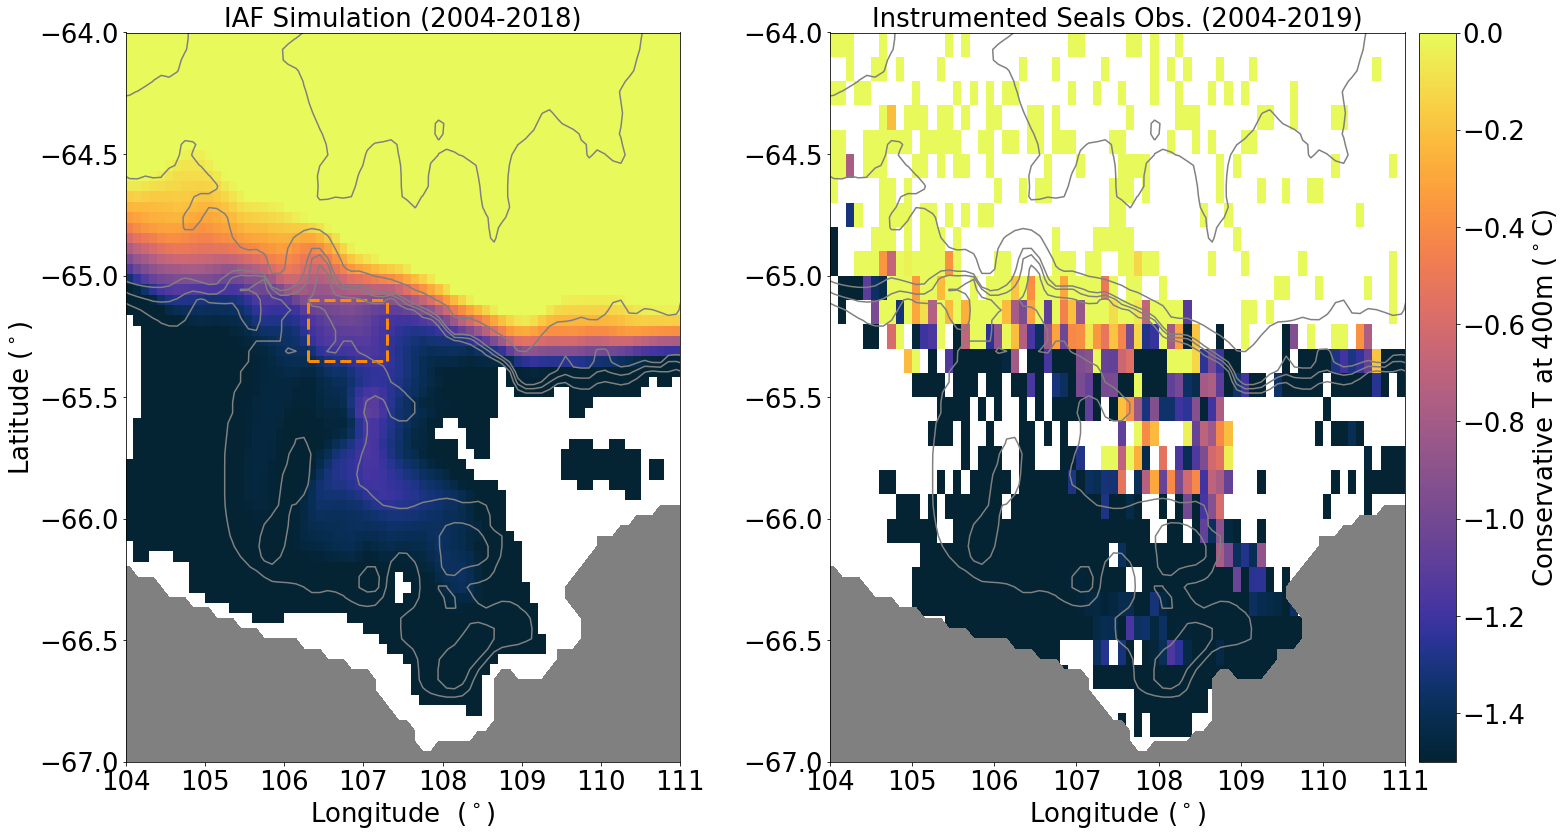

In [51]:
#Prepping variables to plot
fontsize=26

    #for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)        
pc = plt.pcolormesh(temp_400m_12.xt_ocean,temp_400m_12.yt_ocean,
                        temp_400m_12, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

plt.title('IAF Simulation (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label('Conservative T at'+str(depth_slice)+'m ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax1=plt.subplot(2,2,2)    

sc=plt.pcolormesh(binned_meop_temp.lon_bin-360,binned_meop_temp.lat_bin,binned_meop_temp,cmap=cmocean.thermal,vmin=-1.5,vmax=0)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label('Conservative T at '+str(depth_slice)+'m ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
cbar.ax.tick_params(labelsize=fontsize)
plt.title('Instrumented Seals Obs. (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#plt.set_xticks([-255,-254,-253,-252,-251,-250,-249,-248])
ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/Fig2_model_vs_seal_comparison.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### Making a third panel with the control simulation as requested by Laura. 

### Load CONTROL RYF

In [52]:
#session_ryf = cc.database.create_session()
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

first_year = '1958'
last_year = '2019'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [54]:
#depth_slice = slice(400, 6000)
depth_slice = 400
#lat_slice  = slice(-79,-59)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

temp_con = cc.querying.getvar(control,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')                             
temp_con = temp_con.load()

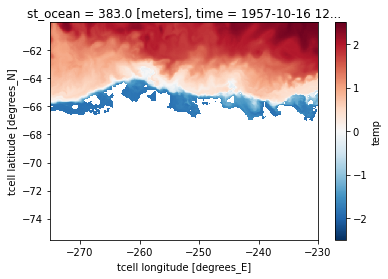

In [55]:
##test if temp is still working after the depth weighting
temp_con[0,...].plot()
#temp_upY.plot()

In [56]:
temp_con = temp_con.mean('time')

In [57]:
temp_con = temp_con.load()

## UNITE THE THREE PLOTS

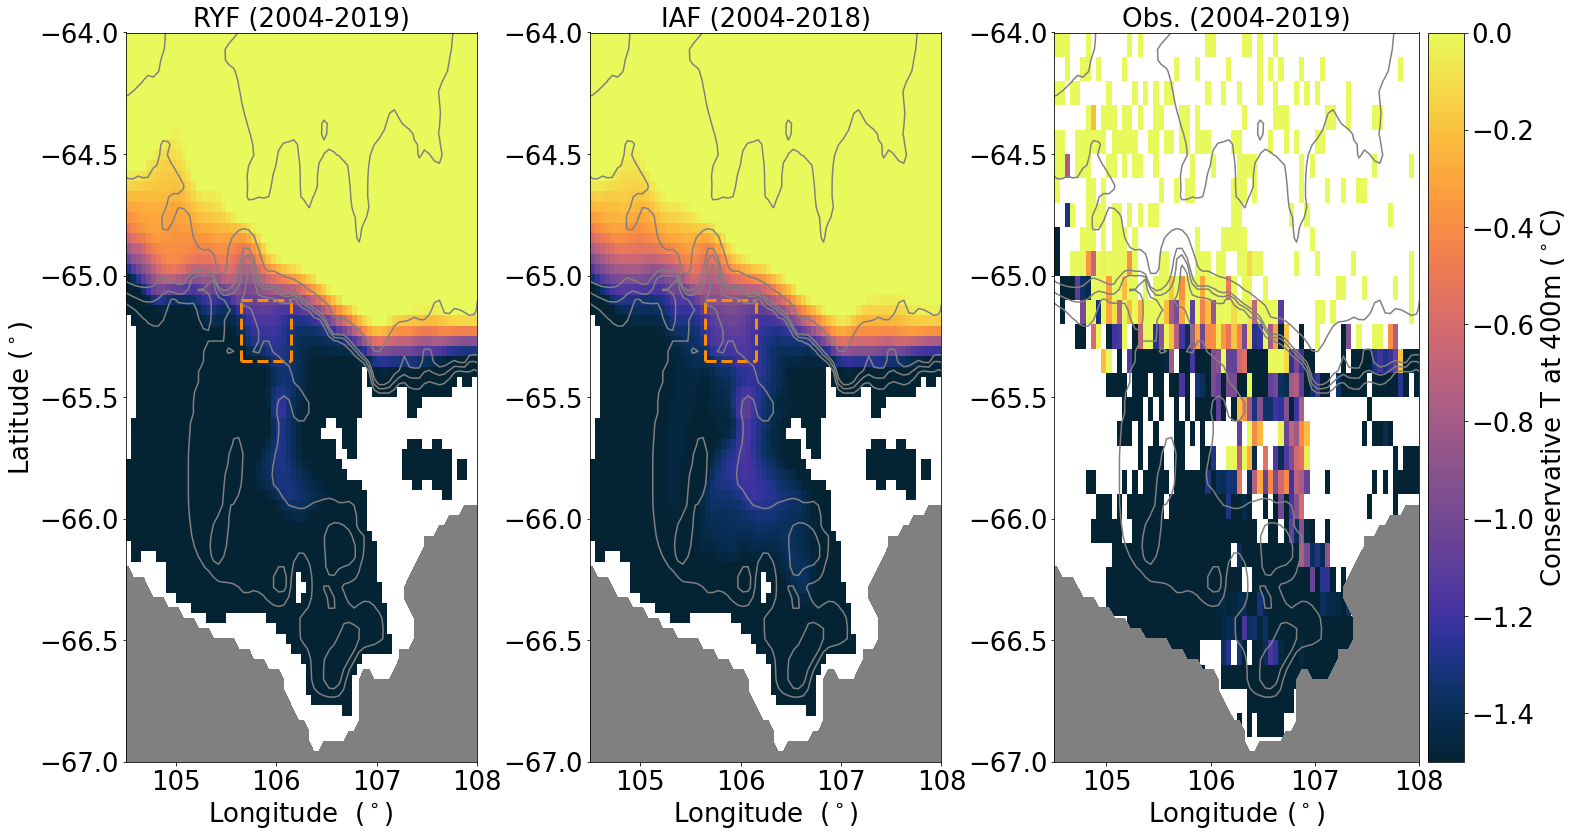

In [59]:
#Prepping variables to plot
fontsize=26

    #for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

ax0=plt.subplot(2,3,1)        
pc = plt.pcolormesh(temp_con.xt_ocean,temp_con.yt_ocean,
                        temp_con, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

plt.title('RYF (2004-2019)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0=plt.subplot(2,3,2)        
pc = plt.pcolormesh(temp_400m_12.xt_ocean,temp_400m_12.yt_ocean,
                        temp_400m_12, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

plt.title('IAF (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[2])

ax1=plt.subplot(2,3,3)    

sc=plt.pcolormesh(binned_meop_temp.lon_bin-360,binned_meop_temp.lat_bin,binned_meop_temp,cmap=cmocean.thermal,vmin=-1.5,vmax=0)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label('Conservative T at '+str(depth_slice)+'m ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
plt.title('Obs. (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#plt.set_xticks([-255,-254,-253,-252,-251,-250,-249,-248])
ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/Fig2_ryf_vs_iaf_vs_seal_comparison.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [ ]:
## 
### Create an SI figure for seal data spatial/time distribution
